In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import uniform_filter1d
from sklearn.preprocessing import StandardScaler
from matplotlib.patches import Rectangle

# Essential Functions
Includes function to detect peaks and valleys of signal. Parameter delta to determine how many peaks/valleys detected (higher delta, fewer peaks)

In [117]:
def peakdet(v, delta, x = None):
    """
    Converted from MATLAB script at http://billauer.co.il/peakdet.html
    Returns two arrays
    
    function [maxtab, mintab]=peakdet(v, delta, x)
    %PEAKDET Detect peaks in a vector
    %        [MAXTAB, MINTAB] = PEAKDET(V, DELTA) finds the local
    %        maxima and minima ("peaks") in the vector V.
    %        MAXTAB and MINTAB consists of two columns. Column 1
    %        contains indices in V, and column 2 the found values.
    %      
    %        With [MAXTAB, MINTAB] = PEAKDET(V, DELTA, X) the indices
    %        in MAXTAB and MINTAB are replaced with the corresponding
    %        X-values.
    %
    %        A point is considered a maximum peak if it has the maximal
    %        value, and was preceded (to the left) by a value lower by
    %        DELTA.
    
    % Eli Billauer, 3.4.05 (Explicitly not copyrighted).
    % This function is released to the public domain; Any use is allowed.
    
    """
    maxtab = []
    mintab = []
       
    if x is None:
        x = np.arange(len(v))
    
    v = np.asarray(v)
    
    if len(v) != len(x):
        print('Input vectors v and x must have same length')
        return
    
    if not np.isscalar(delta):
        print('Input argument delta must be a scalar')
        return
    
    if delta <= 0:
        print('Input argument delta must be positive')
        return
    
    mn, mx = np.Inf, -np.Inf
    mnpos, mxpos = np.NaN, np.NaN
    
    lookformax = True
    
    for i in np.arange(len(v)):
        this = v[i]
        if this > mx:
            mx = this
            mxpos = x[i]
        if this < mn:
            mn = this
            mnpos = x[i]
        
        if lookformax:
            if this < mx-delta:
                maxtab.append((mxpos, mx))
                mn = this
                mnpos = x[i]
                lookformax = False
        else:
            if this > mn+delta:
                mintab.append((mnpos, mn))
                mx = this
                mxpos = x[i]
                lookformax = True

    return np.array(maxtab), np.array(mintab)

def get_peaks_or_valleys(which, x, n, SPACE=300):
    
    """return the indices of n peaks/valleys in given signal x.
    Each peak/valley to be separated by at least <SPACE> samples.
    delta automatically incremented until n beats are detected (after excluding peaks/valleys that are too close to one another).
    """
    
    def get_spaced_valleys(delta):
        if which == "peak":
            vals, _ = peakdet(x, delta)
        else:
            _, vals = peakdet(x, delta)

        # filter peaks/valleys not at a certain val
        LIMIT = 200
        if which == "peak":
            include = [k for k in range(vals.shape[0]) if vals[k,1] > LIMIT]
        else:
            include = [k for k in range(vals.shape[0]) if vals[k,1] < -LIMIT]
        inds, vals = vals[include,0], vals[include,1]

        # ensure SPACE samples between each peak
        valid = [0]
        this_index = 0
        for i in range(len(inds) - 1):        
            next_index = i+1
            diff = inds[next_index] - inds[this_index]
            if diff > SPACE:            
                this_index = i+1
                valid.append(this_index)
            else:
                if (which == "peak" and vals[next_index] > vals[this_index]) or (which == "valley" and vals[next_index] < vals[this_index]):
                    valid.pop()
                    this_index = next_index
                    valid.append(this_index)
            # print(f"i={i}: this_peak={this_index}, valid_ind={valid_ind}")

        return np.uint16(inds[valid]), vals[valid]

    delta = 1000
    inds, vals = get_spaced_valleys(delta)
    num_beats = len(inds)
    # print(inds)

    while num_beats < n:
        SPACE -= 10
        tmp_inds, tmp_vals = get_spaced_valleys(delta)
        diff = tmp_inds[1:] - tmp_inds[:-1]
        mean = np.mean(diff)
        std_lower, std_upper = 0.10, 1
        # print(f"SPACE={SPACE}, diff={diff}, mean={mean}")
        if len([k for k in tmp_inds if k < mean-std_lower*mean]) and not len([k for k in tmp_inds if k > mean+std_upper*mean]):
            break
        inds, vals = tmp_inds, tmp_vals
        num_beats = len(inds)

    if num_beats > n:
        if which == "peak":
            n_prominent_inds = np.argsort(vals)[-n:]
        else:
            n_prominent_inds = np.argsort(vals)[:n]
        inds = [inds[k] for k in range(len(inds)) if k in n_prominent_inds]

    return np.uint16(inds)

def get_value_nearest_to(valleys, accX, value_nearest=0):
    
    """return the indices of <len(valleys)> beats based on given valley indices.
    Beats are the accX value closest to <value_nearest> nearest to each valley
    """

    new_indices = []

    if value_nearest < accX[valleys[0]]:
        which = "peak"
    else:
        which = "valley"

    for valley in valleys:
        new_index = valley
        val = accX[new_index]
        if which == "peak":
            while val > value_nearest:
                new_index -= 1
                val = accX[new_index]
        else:
            while val < value_nearest:
                new_index -= 1
                val = accX[new_index]        
        new_indices.append(new_index)
        # print(f"new_index={new_index}, old_index={valley}")
        
    return np.uint16(new_indices)

# Visualize Individual Trial
Code to visualize data of individual file. To actually create the combined dataset, go straight to section **Create Combined Dataset**.

In [139]:
DATA_PATH = "data/archive/left/"
FILE = "0-4.csv"
df = pd.read_csv(DATA_PATH + FILE, index_col=0)
print(df.shape)
df.tail()

(31071, 7)


,gesture,time,index,middle,ring,pinky,accX
31066,0-4,1.679538e+09,569.0,486.0,585.0,578.0,934.0
31067,0-4,1.679538e+09,569.0,486.0,585.0,578.0,941.0
31068,0-4,1.679538e+09,569.0,486.0,585.0,578.0,937.0
31069,0-4,1.679538e+09,569.0,486.0,585.0,578.0,933.0
31070,0-4,1.679538e+09,569.0,486.0,585.0,578.0,938.0


Frequency: 310.710 Hz
Number of beats: 100


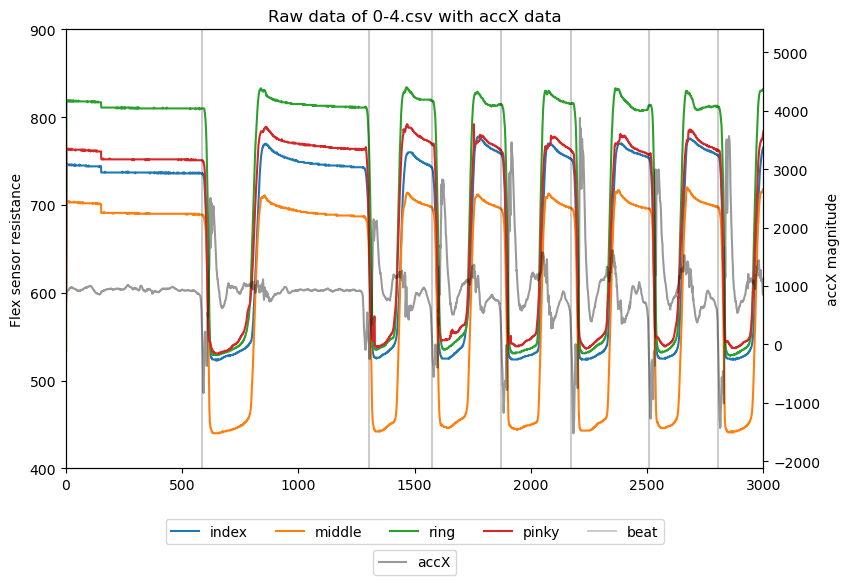

In [142]:
keys = ["index","middle","ring","pinky"]
NUM_BEATS = 100

# get x-axis in seconds
startTime = int(df.iloc[0,1])
endTime = int(df.iloc[-1,1])
x = np.linspace(0, endTime-startTime, df.shape[0])

# get valleys
accX = df['accX'].to_numpy()
accX = accX - np.mean(accX)
peaks = get_peaks_or_valleys("peak", accX, NUM_BEATS, SPACE=300)
valleys = get_peaks_or_valleys("valley", accX, NUM_BEATS, SPACE=300)
beats = get_value_nearest_to(valleys, accX, value_nearest=0)
# print(beats[1:] - beats[:-1])

# print stats
print("Frequency: %.3f Hz" % (df.shape[0]/(endTime-startTime)))
print("Number of beats:", len(beats))

# plot data
fig, ax1 = plt.subplots()
fig.set_size_inches((9, 5.7))
ax2 = ax1.twinx()
for key in keys:
    ax1.plot(df[key].to_numpy(), label=key)
for i in range(len(beats)):
    ax1.axvline(beats[i], color="k", alpha=0.2, label="beat" if not i else "")
ax2.plot(accX, color="k", label="accX", alpha=0.4)
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=5)
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.17), ncol=5)
plt.xlabel("Time (sample)")
ax1.set_ylabel("Flex sensor resistance")
ax2.set_ylabel("accX magnitude")
plt.xlim(0e3,3e3)
ax1.set_ylim((400,900))
plt.title("Raw data of " + FILE + " with accX data")
plt.show()

Offset (should be more than 10):
0


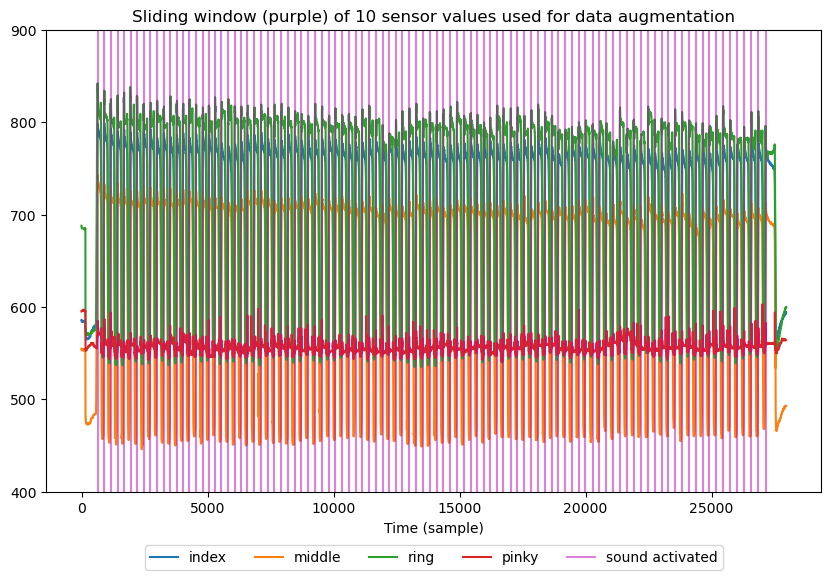

In [18]:
sound_activated = get_value_nearest_to(peaks, accX, value_nearest=0)
timestep = 10
fig, ax = plt.subplots()
fig.set_size_inches((10, 6))
for key in keys:
    ax.plot(np.arange(0, len(x)), df[key].to_numpy(), label=key)
for i in range(len(sound_activated)):
    ax.axvline(sound_activated[i], color="m", alpha=0.5, label="sound activated" if not i else "")
# for i in range(len(beats)):
#     ax.axvline(beats[i], color="k", alpha=0.5, label="beat" if not i else "")

offset = 0
while sound_activated[0] + offset + timestep <= beats[0]:
    ax.add_patch(Rectangle((sound_activated[0] + offset, 400), timestep, 500, color="m", alpha=0.3))
    offset += 1
print("Offset (should be more than 10):")
print(offset)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=5)
ax.set_xlabel("Time (sample)")
# ax.set_xlim(10e3,20e3)
ax.set_ylim((400,900))
plt.title(f"Sliding window (purple) of {timestep} sensor values used for data augmentation")
plt.show()

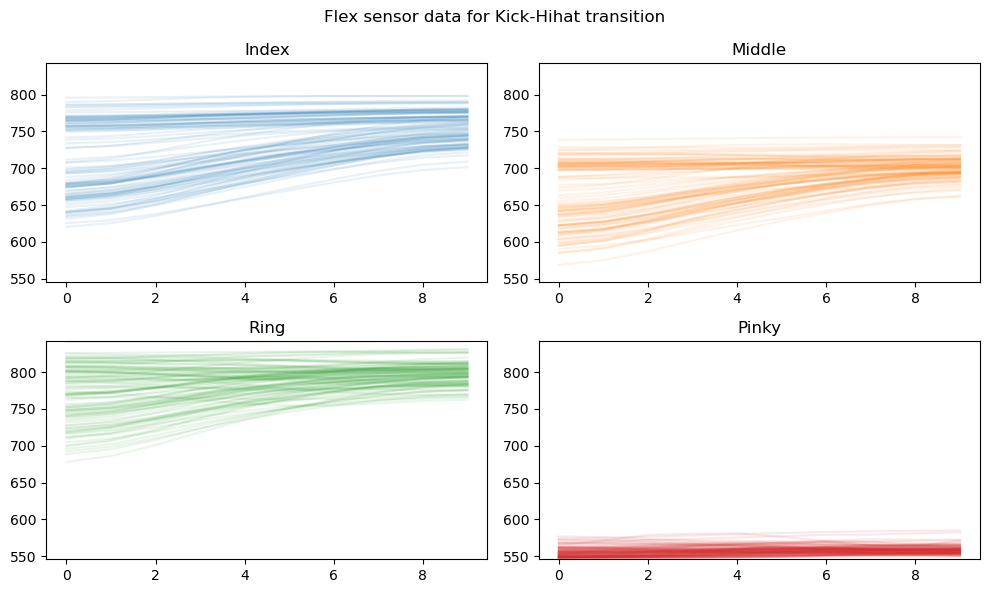

In [19]:
timestep = 10
offset = 0

# get indices of beats
df_gesture = df.loc[:,["index","middle","ring","pinky"]].to_numpy()
X = np.empty([len(beats), timestep, 4])

fig, ax = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(10, 6)

# split, filter and normalize data
alpha = 0.1
for i,idx in enumerate(beats):
    gesture_data = df_gesture[idx - timestep : idx, :]
    filtered_data = uniform_filter1d(gesture_data, axis=0, size=5)
    # for j in range(4):
    #     data_min, data_max = np.min(filtered_data), np.max(filtered_data)
    #     filtered_data[:,j] = (filtered_data[:,j] - data_min) / (data_max - data_min)
    X[i] = filtered_data
    ax[0,0].plot(filtered_data[:,0], color="C0", alpha=alpha)
    ax[0,1].plot(filtered_data[:,1], color="C1", alpha=alpha)
    ax[1,0].plot(filtered_data[:,2], color="C2", alpha=alpha)
    ax[1,1].plot(filtered_data[:,3], color="C3", alpha=alpha)
        
ymin = min(X.flatten()) - 0.5
ymax = max(X.flatten()) + 0.5

ax[0,0].set_title("Index")
ax[0,1].set_title("Middle")
ax[1,0].set_title("Ring")
ax[1,1].set_title("Pinky")
for a in ax.flatten():
    a.set_ylim((ymin, ymax))
# plt.suptitle(FILE)
plt.suptitle("Flex sensor data for Kick-Hihat transition")
plt.tight_layout()
plt.show()

# Create Combined Dataset
Code to actually create the combined dataset. DataFrame has 2000 rows (samples) and 5 columns: index, middle, ring, pinky and label. Labels contain strings representing gesture transitions (e.g. 0-1) and the data samples are lists of 30 samples each.

In [123]:
def create_dataset():
    DATA_PATH = "data/archive/left/"
    NUM_BEATS = 100
    timestep = 10

    files = []
    for filename in os.listdir(DATA_PATH):
        f = os.path.join(DATA_PATH, filename)
        files.append(f)
    files.sort()

    data = {
        "index": [],
        "middle": [],
        "ring": [],
        "pinky": [],
        "label": []
    }
    for i in range(len(files)):
        file = files[i]

        # exclude non CSV files
        if file.split(".")[-1] != "csv" or "NOBEATS" in file:
            continue

        # create dataframe
        df = pd.read_csv(file, index_col=0)

        # get gesture
        gesture = df.iloc[0,0]
        
        # get beats indices
        # get valleys
        accX = df['accX'].to_numpy()
        accX = accX - np.mean(accX)
        vals = get_peaks_or_valleys("peak", accX, NUM_BEATS, SPACE=300)
        beats = get_value_nearest_to(vals, accX, value_nearest=0)
        df_gesture = df.loc[:,["index","middle","ring","pinky"]].to_numpy()    
        print("%s: %d beats" % (file, len(beats)))

        # split, filter and normalize data        
        for i,idx in enumerate(beats):
            gesture_data = df_gesture[idx : idx+timestep, :]
            filtered_data = uniform_filter1d(gesture_data, axis=0, size=10)
            # for k in range(4):
                # filtered_data[:,k] = filtered_data[:,k] - np.mean(filtered_data[:,k])
                # filtered_data[:,k] = filtered_data[:,k] - np.mean(filtered_data)
                # data_min, data_max = np.min(filtered_data), np.max(filtered_data)
                # filtered_data[:,k] = (filtered_data[:,k] - data_min) / (data_max - data_min)
            data["index"].append(list(filtered_data[:,0]))
            data["middle"].append(list(filtered_data[:,1]))
            data["ring"].append(list(filtered_data[:,2]))
            data["pinky"].append(list(filtered_data[:,3]))
            data["label"].append(gesture)

    final_df = pd.DataFrame(data)
    return final_df

In [124]:
final_df = create_dataset()
final_df.to_csv("data_rach_left.csv")

data/archive/left/0-0.csv: 100 beats
data/archive/left/0-1.csv: 100 beats
data/archive/left/0-2.csv: 100 beats
data/archive/left/0-3.csv: 100 beats
data/archive/left/0-4.csv: 100 beats
data/archive/left/1-0.csv: 100 beats
data/archive/left/1-1.csv: 100 beats
data/archive/left/1-2.csv: 100 beats
data/archive/left/1-3.csv: 100 beats
data/archive/left/1-4.csv: 100 beats
data/archive/left/2-0.csv: 100 beats
data/archive/left/2-1.csv: 100 beats
data/archive/left/2-2.csv: 100 beats
data/archive/left/2-3.csv: 100 beats
data/archive/left/2-4.csv: 100 beats
data/archive/left/3-0.csv: 100 beats
data/archive/left/3-1.csv: 100 beats
data/archive/left/3-2.csv: 100 beats
data/archive/left/3-3.csv: 100 beats
data/archive/left/3-4.csv: 100 beats
data/archive/left/4-0.csv: 100 beats
data/archive/left/4-1.csv: 100 beats
data/archive/left/4-2.csv: 100 beats
data/archive/left/4-3.csv: 100 beats
data/archive/left/4-4.csv: 100 beats
